# Overview



## Introduction to functional magnetic resonance imaging (fMRI)

In this session, we will learn about fMRI data properties by loading, manipulating and visualizing it.

# Goals for today

We will go over some important concepts of data manipulation and visualization in fMRI, including: 

* Displaying a data (functional volumes) as an image (`plt.imshow()`)
* Selecting an appropriate colormap for data visualization
* Displaying a 3D array as a mosaic or contact sheet of images
* Plotting timecourses of fMRI data
* Masking / unmasking of fMRI data

By the end, we will have written functions to:

* Display a 3D array as a mosaic of images
* Unmask an array
* Normalize a timeseries

## Short overview of fMRI 

Functional Magnetic Resonance Imaging, or fMRI, is a measure of brain activity over time. FMRI data is acquired using a special pulse sequence designed to measure changes in the magnetic properties of the blood flow using the Magnetic Resonance Imaging (MRI) scanner.

<img src="figures/mri_scanner.png" style="height: 400px;">

The functional signal we measure with fMRI is *not* an electrical neural signal (as in EEG, ECoG, or electrophysiology). It is a magnetic signal related to the properties of brain tissue, and it is dominated by blood flow. Blood flow is related to neural activity, because firing neurons need oxygen. The process of firing involves letting electrically charged ions into a cell and actively pumping them back out again, which is metabolically demanding. So once a region of the brain becomes active (once the neurons start firing), metabolism in that region is high, oxygen gets stripped off of hemoglobin molecules in red blood cells in the area (thereby changing the magnetic properties of hemoglobin, creating a deoxyhemoglobin). This initiates a complex process to increase blood flow to the electrically active area. 

<img src="figures/deoxyhemoglobin.png" style="height: 400px;">


The specific mechanisms that lead from neural activity to changes in blood flow are (a) not well understood, and (b) beyond the scope of this class. For now, just know that there are several ways to measure functional responses with MRI, and the specific one that we work with is the Blood Oxygenation Level Dependent Response, or the BOLD response. 

### fMRI has high spatial but low temporal resolution

We have belabored this here a little because this complexity should always be a source of humility for anyone working with fMRI or trying to interpret fMRI results. It is an **indirect, slow measure** - and these considerations strongly constrain the kinds of experiments you can do with fMRI and the conclusions you can draw from those experiments.

An important practical upshot of this for our purposes is that the signal we measure changes much more slowly than the signal we measure in EEG or ECoG. Responses emerge over seconds, not milliseconds.

<img src="figures/imaging_modalities.png" style="height: 400px;">

                                      Sejnowski et al., Nature Neurosci., 2014




One fMRI image (fMRI volume) is acquired for a given unit of time called a repetition time (TR). A TR is typically 1-2 seconds *(usually 1.0, 1.5, or 2.0 seconds)*. Every image records the activity in the brain at a given point in time. The following image shows a single volume of fMRI data (one two-second snapshot of brain activity).

<img src="figures/fig1.png" style="height: 400px;">

The dimensions of the brain volume measured by fMRI can vary. Each individual fMRI measurement unit is called a *voxel*, which is short for volumetric pixel. The voxels in this data are about 2.4 x 2.4 x 4.0 mm (X x Y x Z) in size. 

### FMRI activity in time

Once a neural event is triggered by a stimulus presentation the vascular system needs to respond to the need for glucose and oxygen in that specific brain area. This can take up to 1-2 seconds. Hence the hemodynamic response lags the triggered event by 1-2 seconds, which peaks around 5 seconds after the stimulus onset.

<img src="figures/lagged_activity.png" style="height: 400px;">

### Example fMRI experiments 

#### Viewing natural images 

<img src="figures/fmri_example_experiment.png" style="height: 400px;">

#### Fusiform Face Area (FFA)

<img src="figures/ffa.png" style="height: 400px;">



## FMRI as a *mapping* technique
The scanning volume for the data we will use here consists of 30 transverse slices (i.e. Z is between 0 and 29). Transverse slices are horizontal, i.e., approximately parallel to the plane of the eyes and ears. Each slice corresponds to a 2D image of 100 x 100 voxels.

We can measure fMRI responses across the whole brain. Therefore fMRI can be seen as a *mapping* technique. In order to make brain maps, we have to be able to match measured voxel responses to the participant's brain anatomy. Using a different type of MRI sequence, we can collect a **structural scan** (also called **anatomical scan**), and obtain a high resolution image of a participant's brain. Here is an example:

<img src="figures/MPRAGE_wcortex.png">

Most MRI measures activity in the cerebral cortex, or the outer layer of the brain. Using automated reconstruction software (and some manual editing), it's possible to build a 3D representation of the shape of the subject's cerebral cortex:

<img src="figures/cortex_3views.png">


In further lectures, we will learn how to overlay functional data onto the high resolution cortical representation for each individual the subject, so that we can make sense of the data.


## Storing fMRI data for data analysis

We store fMRI data as a matrix. This means that each volume (a timepoint) in the experiment will correspond to a row in the matrix, and each voxel will correspond to a column in that matrix. For this reason, we need to make sure the criteria we use to move each 3D image to a matrix row is preserved and this operation is inverted. Let's look at an example.

<img src="figures/fmri_dimensions.png">


## Loading data

fMRI data is stored in a variety of formats. The medical imaging community has a standardized image format called Digital Imaging and Communications in Medicine (DICOM) to handle and store raw medical imaging data. When data is collected using the MRI scanner each volume is stored in a DICOM file that contains both a header and the image data. The DICOM header stores useful information about the participant's name, pulse sequence, the type of scan, image dimensions, etc. (Another popular medical imaging format is the Analyze format, where the image and header file are stored separately.) You can read about these file formats [here](http://people.cas.sc.edu/rorden/dicom/index.html).

Before we start analyzing the data we convert the raw DICOM files into the commonly used Neuroimaging Informatics Technology Initiative (nifti) file format. Files stored in this format usually have the extension .nii or .nii.gz. 

We will use the `nibabel` python module to load data that is stored such data formats.

In [1]:
import nibabel
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt  # for visualization

# Set defaults for matplotlib plotting in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In the following we will load one run (also referred to as a scan) worth of fMRI data that was stored as a nifti file format. 

In [2]:
# Create a nifti (nii) proxy object
fname = '/home/shared/cogneuro-connector/data/fmri/categories/sub01_categories1_1.nii.gz'
nii = nibabel.load(fname) 

# This object stores the infomation *about* the fMRI data stored in the file. 
# This meta-data can be accessed via attributes of the `nii` object.
print('nii.in_memory : ', nii.in_memory)
print('nii.shape : ', nii.shape)

nii.in_memory :  False
nii.shape :  (100, 100, 30, 120)


In [3]:
# Retrieve actual data as an array
data = nii.get_data()
print('nii.in_memory : ', nii.in_memory)
print('data shape : ', data.shape)

nii.in_memory :  True
data shape :  (100, 100, 30, 120)


The dimensions of the data are (X, Y, Z, T) (T is time, in TRs). Thus, there are 120 volumes (120 time points). Each volume has 30 horizontal or transverse slices with 100 x 100 pixels.

<img src="figures/slices.png" style="height: 200px;">

#### Transpose data

When we work with functional images it is in general more convenient (for reasons like averaging over time, transfering data to a standard units, etc.) to have the data in T, Z, Y, X format. This is the opposite of the conventions you've seen so far for EEG / ECoG data. 

When we worked with EEG/ECoG data in the first half of the class, time was the *last* axis; here, time is the *first* axis. The reasons for this convention will become more obvious as we go, and we see how this convention makes for convenient syntax and shortcuts. 

Hence, we will use the `transpose` function  of the numpy package (or `.T` method of numpy arrays) to make this dimensional switch.

In [4]:
# Transpose the data
dataT = np.transpose(data)

# Or, equivalently
dataT_ = data.T

print("dataT shape :", dataT.shape)
print("dataT_ shape : ", dataT_.shape)

dataT shape : (120, 30, 100, 100)
dataT_ shape :  (120, 30, 100, 100)


#### assert function
You can check whether to variables are the same using the `assert` function.

In [5]:
a = 2 
b = 1
assert a==b

AssertionError: 

You can also append an error message. This message will be printed if the two are not equal

In [6]:
assert a==b, 'these two are not equal!'

AssertionError: these two are not equal!

### Breakout session: Explore the function transpose

> Now test whether dataT and dataT_ are the same using assert

> What does transpose do to a 2D array? To an array > 2D? How could you figure this out? 

In [7]:
# Are dataT and dataT_ the same?
### STUDENT ANSWER
assert np.all(dataT==dataT_), "Something went wrong! Check transpose."

In [8]:
# Pause for exploration of transpose
# First create some 2D array
x = np.array([np.arange(5), np.arange(5)+10])
print(x)

[[ 0  1  2  3  4]
 [10 11 12 13 14]]


In [9]:
# Transpose the array
### STUDENT ANSWER
print(x.T)

[[ 0 10]
 [ 1 11]
 [ 2 12]
 [ 3 13]
 [ 4 14]]


In [10]:
# Check out the function "flatten"
### STUDENT ANSWER
print(x.flatten())

[ 0  1  2  3  4 10 11 12 13 14]


In [11]:
a = np.arange(20)
print(a)

# Now reshape the array a into a 4x5 dimensional array
### STUDENT ANSWER
a = a.reshape(4,5)
print('')
print(a)
print(a.T)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]
[[ 0  5 10 15]
 [ 1  6 11 16]
 [ 2  7 12 17]
 [ 3  8 13 18]
 [ 4  9 14 19]]


## Exploring the data

For fMRI, the functions we will use to explore the data are in general more basic than the functions we used in the first part of the class. We will not use a single module like MNE to make standard plots; we will construct our own!

This is a little more work, but is very generalizable to other kinds of analyses, and if you get good at it you can make exactly the plot of your data that you want.

One of the first questions about a data set (after its size) that you should explore is 

    "What is the scale (min/max) of the data?". 

Afterwards you may be interested to know its mean, standard deviation, and how in general the data looks like and make a histogram plot of the data.

In [12]:
# Keep data transposed
data = dataT

del dataT, dataT_
print(data.shape)

(120, 30, 100, 100)


In [13]:
# Find out the scale of the data
print(np.min(data), ', ', np.max(data)) 

# Find out its mean
print(np.mean(data))

# Find out its mean
print(np.std(data))

-28.1915265253 ,  2843.43579235
192.02111475
344.510302536


(120, 30, 100, 100)
[  0.           5.12470758  11.00099354   1.34162263   7.27446371
  16.25841349   8.80028226  10.82020729   5.34590164   9.50756447]


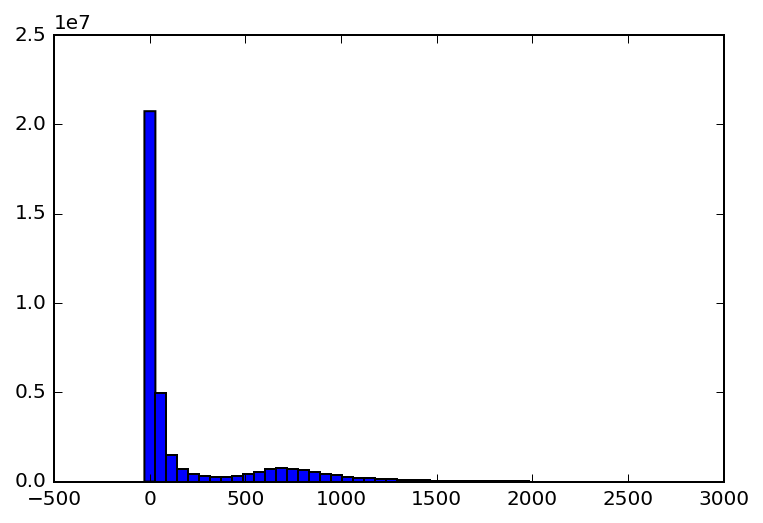

In [14]:
# Make a histogram of the data
print(data.shape)
print(data.flatten()[:10])
_ = plt.hist(data.flatten(), bins=50)

### Breakout session:

> - What does this tell you about the data? 

> - What are the axes on this plot? 

### Plot the timecourse of a single voxel
Now we can plot the timecourse for one voxel somewhere in the middle of the brain (e.g. at Z=10, Y=34, X=34)

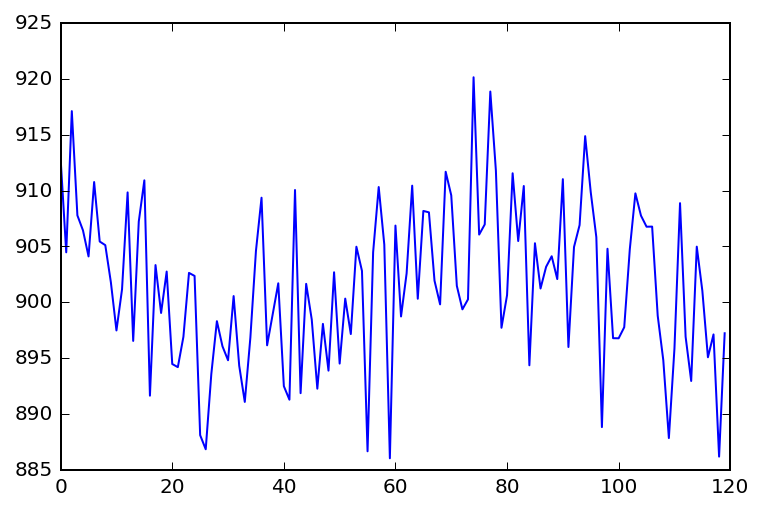

In [15]:
_ = plt.plot(data[:, 10, 34, 34])

### Breakout session:
> - Save all transverse slices for a sagittal and coronal axis (you can choose any number), in a variable called `transverse``

> - Make a plot for all transverse slices (different voxels are plotted in the same figure). Label the axis. What does this plot tell us?

> - Transpose the transverse variable and plot. Label the axis accordingly. What does this plot tell us?

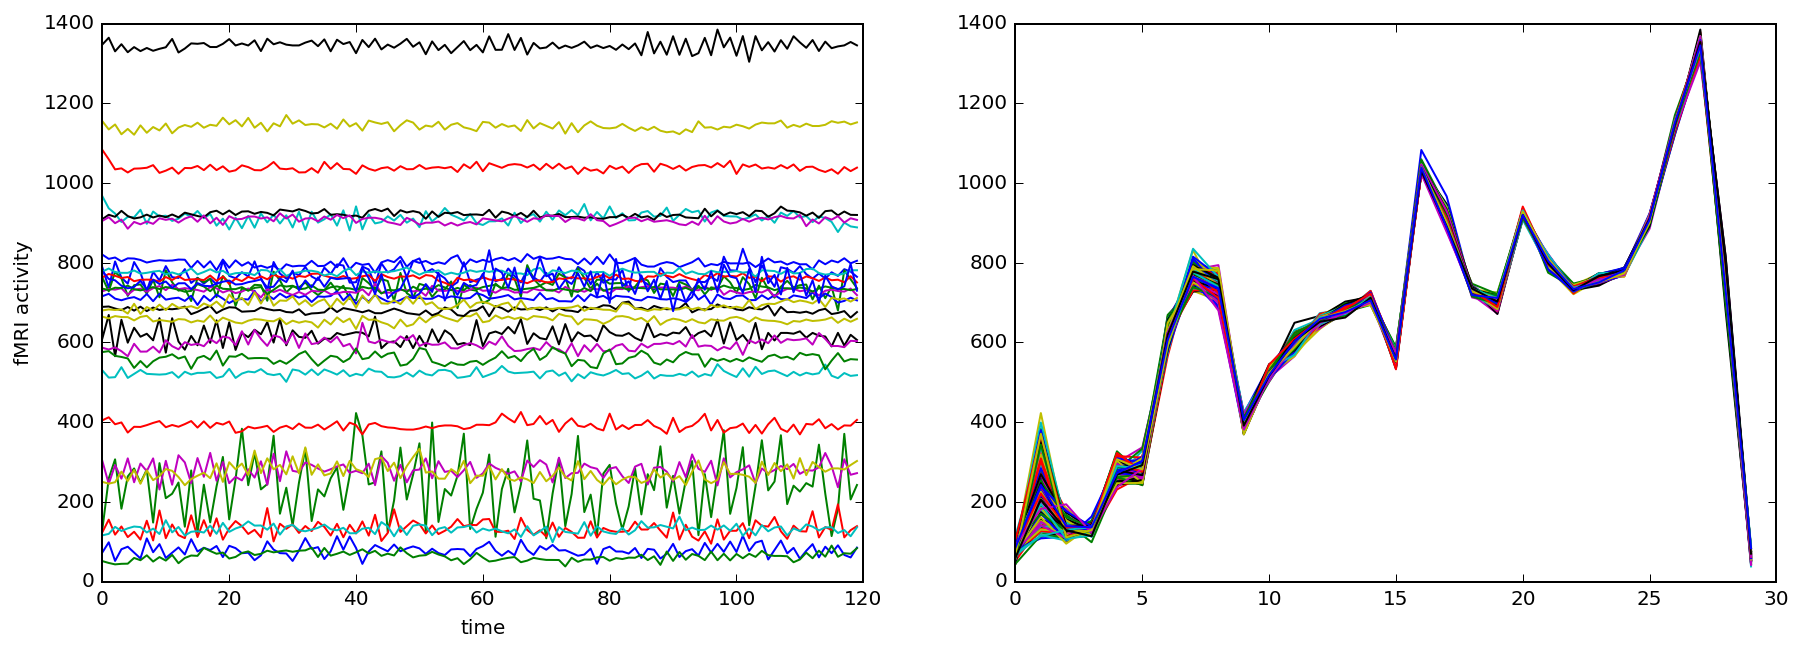

In [16]:
### STUDENT ANSWER
transverse = data[:,:,45,45]
f, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(transverse);
axs[0].set_xlabel('time')
axs[0].set_ylabel('fMRI activity')

axs[1].plot(transverse.T);

Note that we have 30,000 measurements to plot like this. So we *could* make a plot like the eeg representations that we had, but those were pretty busy even with 60 lines. So, instead, we will view our data as images.

## Displaying data as an image

First, we will get a broader view of the first volume of our data. The (T, Z, Y, X) dimension ordering that we have for the data makes it easy to select volumes (time snapshots of brain activity).

Below are some ways to select volumes:

In [17]:
# We can select one volume like this: 
first_volume = data[0, :, :, :]

# Or like this: 
alt_first_volume1 = data[0, ...]

# Or like this: 
alt_first_volume2 = data[0]

# These are all the same1
assert np.all(first_volume==alt_first_volume1)
assert np.all(first_volume==alt_first_volume2)

### Visualizing the horizontal slice
Let's look at an example of a horizontal slice from the first volume. This can be done by selecting one of the slices as follows:

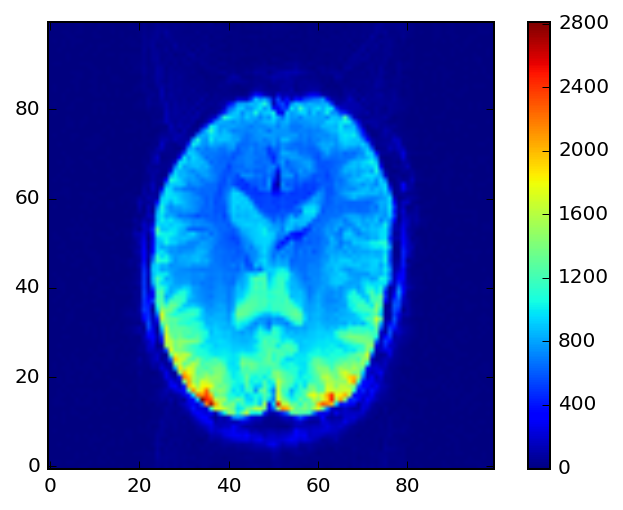

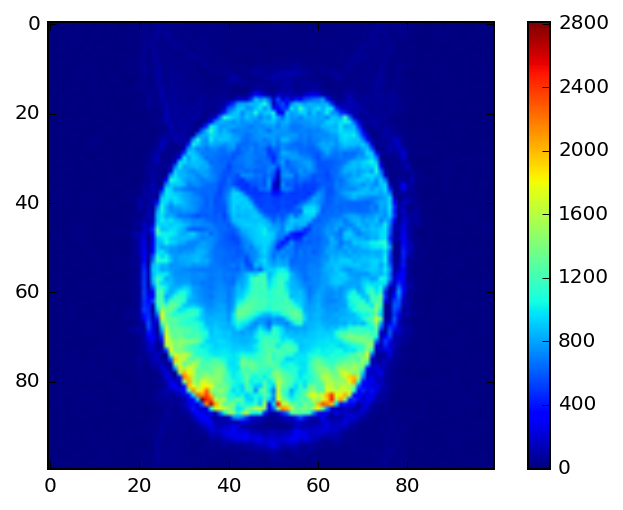

In [18]:
# Z=15 is halfway through the volume we have scanned
slice_horizontal = first_volume[15,:,:]

# You can set the image origin [0,0] to be in the lower left corner
# by using origin='lower'
plt.figure()
im = plt.imshow(slice_horizontal, origin='lower') 
_ = plt.colorbar(im)

# Alternative:
plt.figure()
im = plt.imshow(slice_horizontal[::-1]) 
_ = plt.colorbar(im)

### Breakout session:
> - Plot other slices to see how the shape of the brain is different
> - Change the properties of the figure. Explore the keyword arguments for imshow, see what each does! (hints: show axes, change colormap, what about vmin and vmax values, set those)

Link to blog post about colormaps!

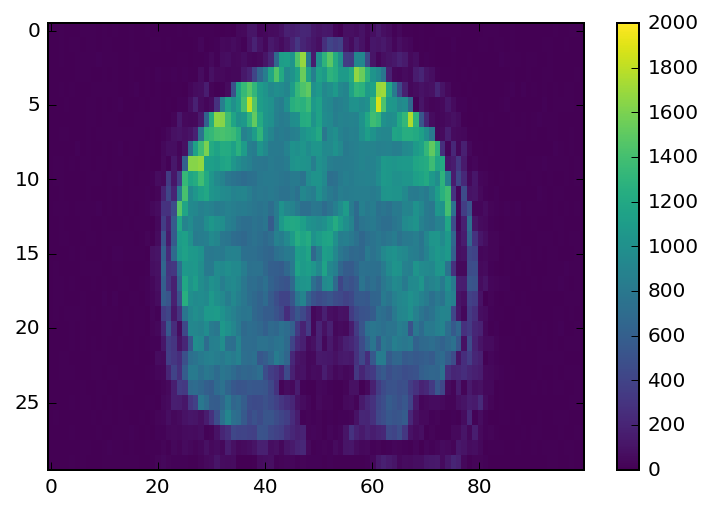

In [19]:
### STUDENT ANSWER
slice_example = first_volume[:,40,:]

# Make sure you give examples of how to set aspect, interpolation
im = plt.imshow(slice_example[::-1], interpolation='nearest', aspect='auto', cmap='viridis', vmin=0, vmax=2000)
_ = plt.colorbar(im)

### Breakout session:
> Write a small helper function that takes a slice number as an input returns the data (2D array) of that slice
> Plot this image

(100, 100)


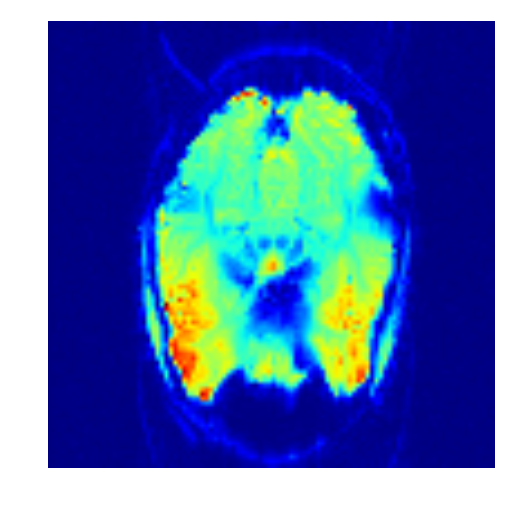

In [20]:
### STUDENT ANSWER
def get_transverse_slice(slice_number, volume):
    """Given an integer and a 3D volume, this function returns the data of 
    that horizontal slice """ 
    img = volume[slice_number, :, :]
    return img

img = get_transverse_slice(10, first_volume)
print(img.shape)
_ = plt.imshow(img[::-1])
_ = plt.axis('off')


### Breakout session: Visualizing sagittal and coronal views
We can also slice the brain on different axis to obtain sagittal and coronal slices. 

> Try to plot these below. We have not told you which dimension corresponds to slicing the brain in a sagittal or coronal view. You should try the different axes and find it out.

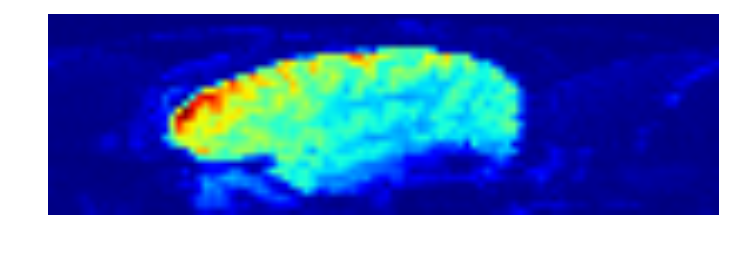

In [21]:
# Select a sagittal slice and plot
### STUDENT ANSWER
i_slice = 30
slice_sagittal = first_volume[:, :, i_slice]
im = plt.imshow(slice_sagittal, origin='lower')
_ = plt.axis('off')

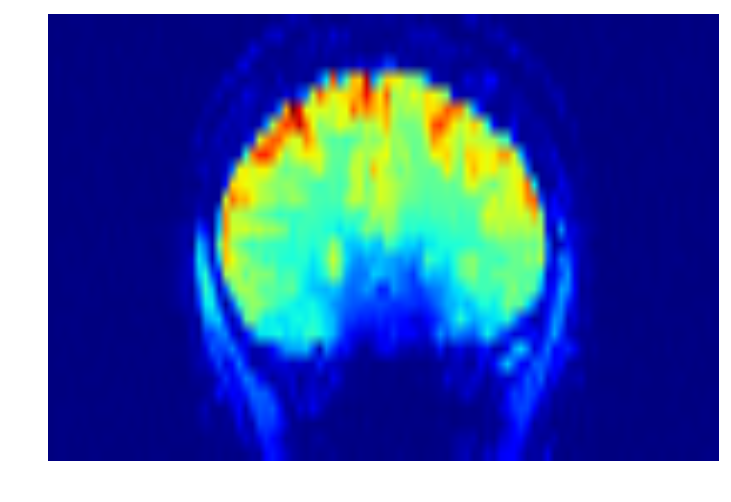

In [22]:
# Select a coronal slice and plot
### STUDENT ANSWER
i_slice = 30
slice_sagittal = first_volume[:,  i_slice, :]
im = plt.imshow(slice_sagittal, aspect='auto', origin='lower')
_ = plt.axis('off')

### Changing matplotlib default parameters

You can set the default colormap, default interpolation or many other parameters in `matplotlib.rcParams`.

For example to set all the colormaps in this `ipython` session to the colormap 'viridis' we can use the following line:
    * `matplotlib.rcParams['image.cmap'] = 'viridis'` # or whatever your favorite map is

In [23]:
import matplotlib
matplotlib.rcParams['image.cmap'] = 'viridis' # or whatever your favorite map is e.g. 'gray', 'hot'
matplotlib.rcParams['image.interpolation'] = 'nearest'
# matplotlib.rcParams['image.aspect'] = 'auto'

An alternative way to change a figure's properties is to create a dictionary of keywords that can be used as a  keyword argument to the `imshow` function.

This has the advantage of not setting the default parameters. Yet, we can easily change a number of parameters in the `imshow` function by just passing the keywords dictionary to the `imhsow` function. The following cell is demonstrating this:

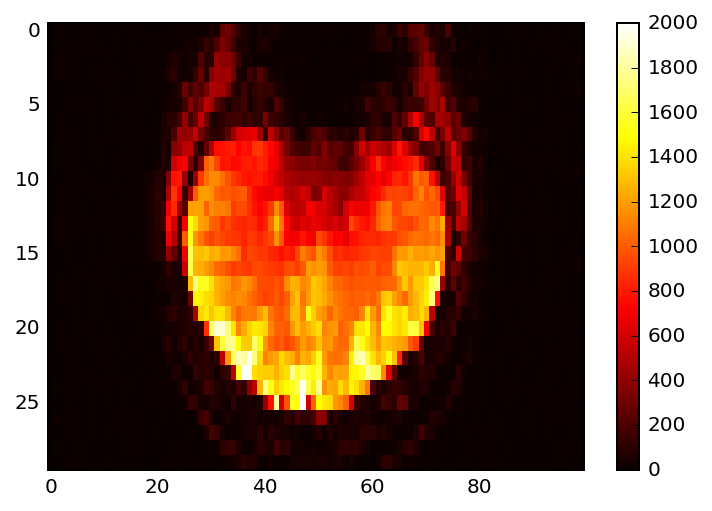

In [24]:
im_kws = dict(aspect='auto', vmin=0, vmax=2000, cmap='hot', interpolation='nearest') 
plt.imshow(first_volume[:,  30, :], **im_kws)
plt.colorbar()

### Plot all horizontal slices

Let's try to make a plot with all of the horizontal slices, so we can see one entire 3D volume at once. For this, we will use the `subplot()` function in matplotlib:

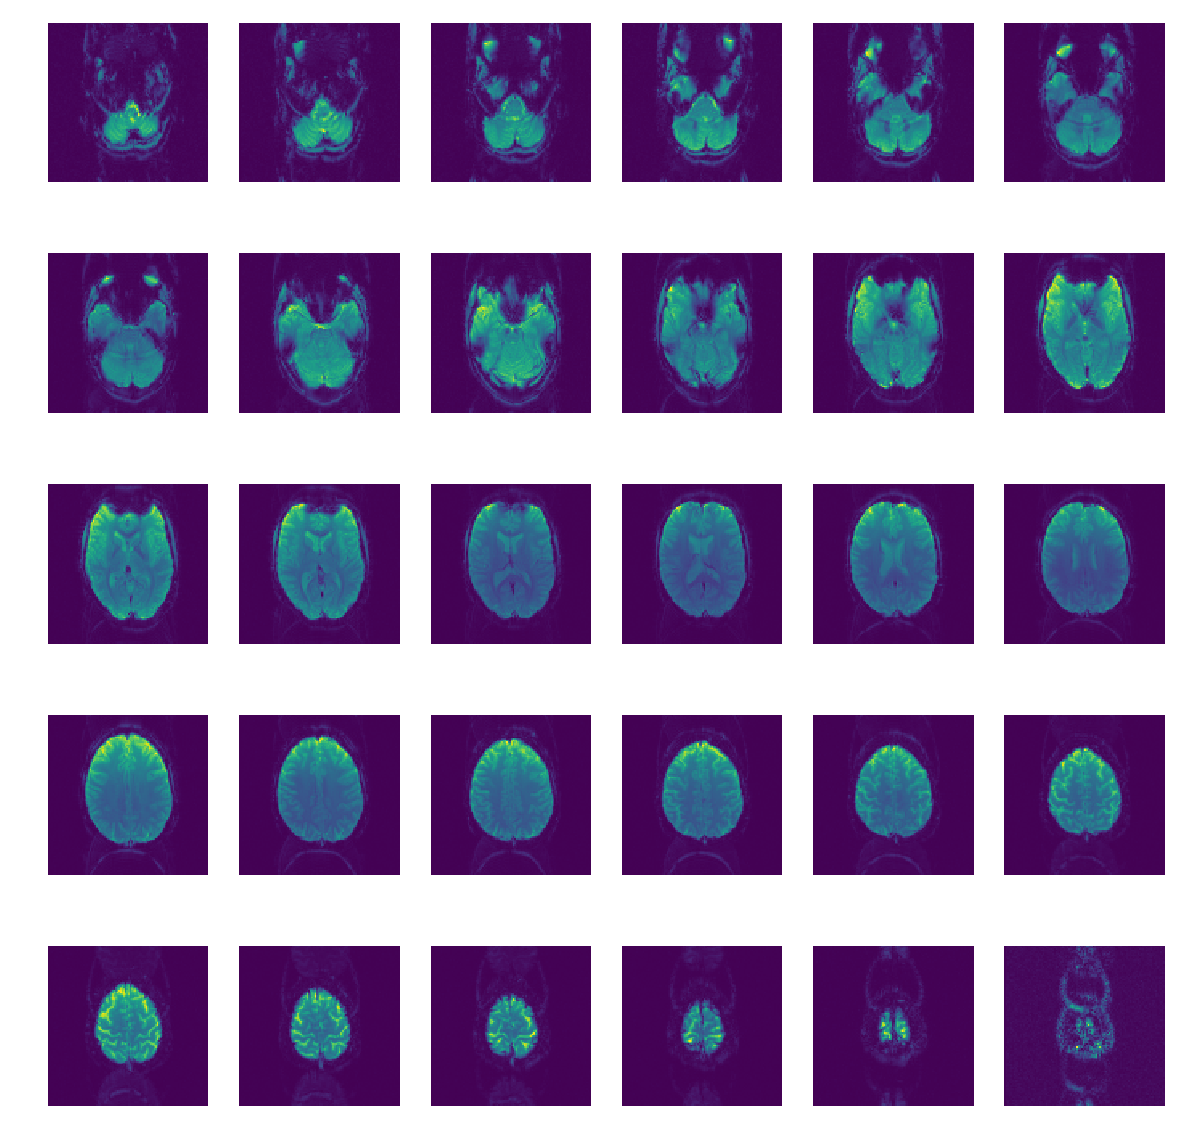

In [25]:
fig = plt.figure(figsize = (10,10))
n_slices = 30
nrows, ncols = 5, 6
for s in range(n_slices):
    ax = fig.add_subplot(nrows, ncols, s+1)
    slice_horizontal = first_volume[s,:,:]
    plt.imshow(slice_horizontal)
    ax.axis('off')

Now let's make a function that plots the above:

In [26]:
def plot_horizontal_slices(vol, **kwargs):
    fig = plt.figure(figsize=(10,10))
    nslices = vol.shape[0]
    subplot_size = np.ceil(np.sqrt(nslices))
    for s in range(nslices):
        ax = fig.add_subplot(subplot_size, subplot_size, s+1) 
        slice_horizontal = vol[s,:,:]
        plt.imshow(slice_horizontal, **kwargs)
        ax.axis('off')

### Breakout session:
> Call the above function (plot_horizontal_slices), and try out different plotting arguments (e.g. change the colormap, change the interpolation, etc.):

In [27]:
### STUDENT ANSWER